Testing code for validating the base policy

In [1]:
import torch
import torch.nn as nn  # noqa: F401
import numpy as np
from tqdm import tqdm

import safety_gymnasium

from rl_vcf.rl.algos.sac.core import MLPActorCritic
from rl_vcf.rl.utils.make_env import make_env_safety
from rl_vcf.rl.utils.get_actor_structure import get_actor_structure
from rl_vcf.validate.utils import ScenarioDatabase, estimate_epsilon

In [2]:
seed = 0
device = "cuda"
num_envs = 8
envs = safety_gymnasium.vector.SafetySyncVectorEnv(
    [
        make_env_safety(
            "SafetyPointReachAvoidReset1-v0",
            i,
            seed + i,
            False,
            5,
            False,
        )
        for i in range(num_envs)
    ]
)

In [3]:
# Load state dict
loaded_state_dict = torch.load(
    "../torch/test_policy.pt", weights_only=True, map_location=device
)

# Construct agent from state dict
loaded_hidden_sizes, loaded_activation = get_actor_structure(
    loaded_state_dict, envs.single_observation_space, envs.single_action_space
)

agent = MLPActorCritic(
    envs.single_observation_space,
    envs.single_action_space,
    loaded_hidden_sizes,
    eval("nn." + loaded_activation + "()"),
)
agent.pi.load_state_dict(loaded_state_dict, strict=True)
agent.to(device)

# Prevent storing gradients
for p in agent.parameters():
    p.requires_grad = False

In [4]:
max_episode_length = 1000
num_scenarios = 1000
# Initialize scenario information database
scenario_database = ScenarioDatabase(num_envs, max_episode_length, num_scenarios)

In [5]:
print(scenario_database.active_scenarios)
print(scenario_database.timesteps)
print(scenario_database.scenario_data[1][999:])
print(max(scenario_database.active_scenarios))

[0 1 2 3 4 5 6 7]
[0 0 0 0 0 0 0 0]
[False False]
7


In [6]:
# ---
# TESTING:
# This is where task success flags for the active scenarios are found
goal_achieved = np.full(num_envs, False, dtype=bool)
# This is where the done flags are found
done = np.full(num_envs, False, dtype=bool)

# Randomly generate task success flags
p_goal = 0.01
# Randomly generate done flags (term | trunc)
p_done = 0.0002
# ---

# VALIDATION LOOP:

# Instantiate progress bar
pbar = tqdm(total=scenario_database.num_scenarios)
# While we haven't collected all required scenarios
while any(scenario_database.active_scenarios < scenario_database.num_scenarios):
    # ---
    # TESTING: environment step (and goal achieved reasoning) will go here
    # Randomly generate done flag (represents constraint violation)
    done = np.random.rand(num_envs) < p_done
    # Randomly generate goal flag (represents goal achievement)
    goal_achieved = np.random.rand(num_envs) < p_goal
    # If the goal was achieved, mark the task as done
    done = done | goal_achieved
    # ---

    previous_active_scenarios = scenario_database.active_scenarios.copy()

    # If the scenario has reached the max episode length, mark as done
    scenario_database.update(done, goal_achieved)

    num_scenarios_complete = sum(
        previous_active_scenarios != scenario_database.active_scenarios
    )
    pbar.update(num_scenarios_complete)

    # ---
    goal_achieved = np.full(num_envs, False, dtype=bool)
    done = np.full(num_envs, False, dtype=bool)
    # ---

# Close progress bar
pbar.close()

print(scenario_database.get_num_successes())
print(scenario_database.get_num_failures())

100%|██████████| 1000/1000 [00:00<00:00, 9289.81it/s]

[ 15  25  42 ... 984 984 984]
[985 975 958 ...  16  16  16]


In [7]:
print(scenario_database.active_scenarios)
print(scenario_database.timesteps)

[1004 1002 1005 1007 1000 1001 1006 1003]
[0 0 0 0 0 0 0 0]


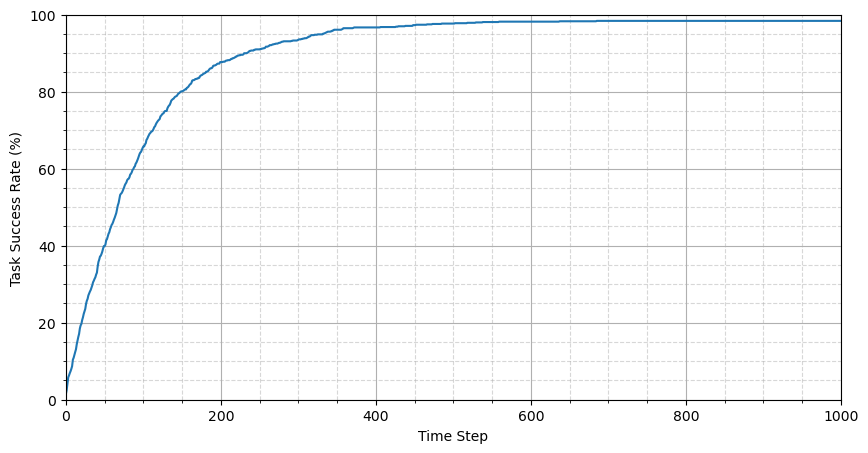

In [8]:
import matplotlib.pyplot as plt

# Plot task success rate
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(scenario_database.get_num_successes() / scenario_database.num_scenarios * 100)
ax.set_xlim([0, max_episode_length])
ax.set_ylim([0, 100])
ax.set_xlabel("Time Step")
ax.set_ylabel("Task Success Rate (%)")
ax.minorticks_on()
ax.grid(which="major")
ax.grid(which="minor", linestyle="--", alpha=0.5)

In [9]:
N_test = 10
k_test = 9
conf_test = 0.95
epsilon_test = estimate_epsilon(conf_test, N_test, k_test)
print(epsilon_test)

0.9948838031081764


In [10]:
# Test numerical result for epsilon
import math

conf = 0.99
k = 3

epsilon = estimate_epsilon(conf, num_scenarios, k, it_max=100, tol=1e-5)
print(epsilon)

test_beta = sum(
    math.comb(num_scenarios, i) * (epsilon**i) * ((1 - epsilon) ** (num_scenarios - i))
    for i in range(k + 1)
)
test_conf = 1 - test_beta
print(test_conf)

0.01001739501953125
0.9900560675132372


In [11]:
epsilons = scenario_database.get_all_epsilons(0.99)

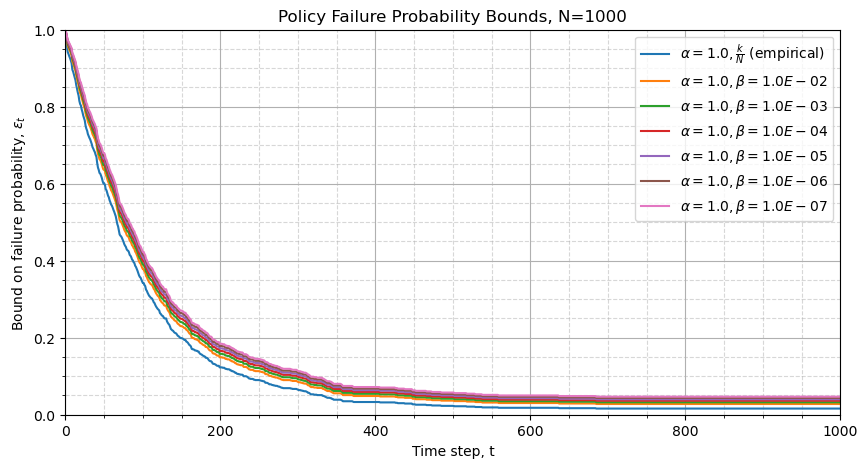

In [12]:
fig, ax = scenario_database.plot_epsilons(
    plot_empirical=True,
    confs=[0.99, 0.999, 0.9999, 0.99999, 0.999999, 0.9999999],
)

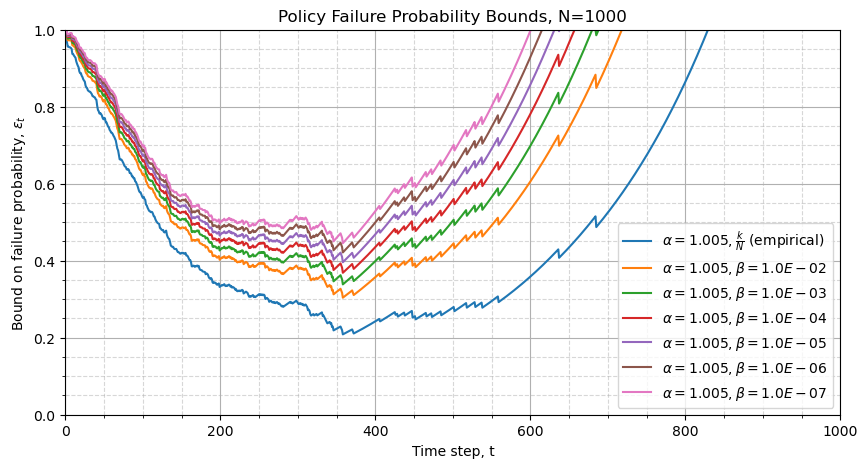

In [13]:
fig, ax = scenario_database.plot_epsilons(
    plot_empirical=True,
    confs=[0.99, 0.999, 0.9999, 0.99999, 0.999999, 0.9999999],
    alphas=[1.005],
)

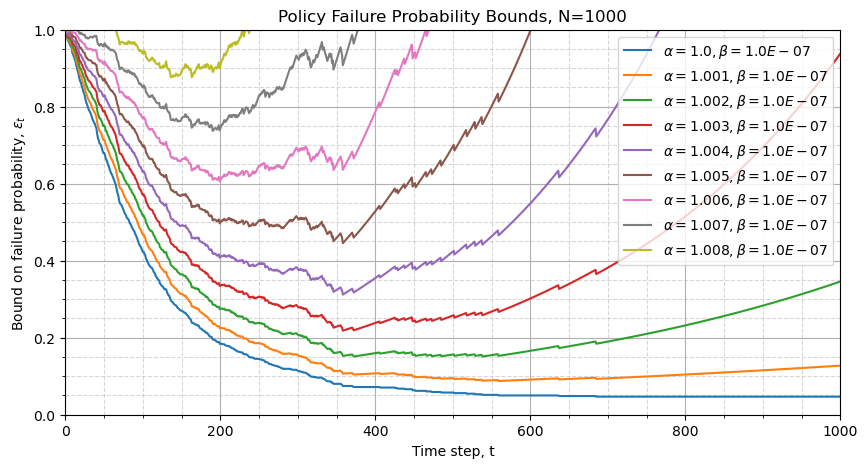

In [14]:
fig, ax = scenario_database.plot_epsilons(
    plot_empirical=False,
    confs=[0.9999999],
    alphas=[1.0, 1.001, 1.002, 1.003, 1.004, 1.005, 1.006, 1.007, 1.008],
)

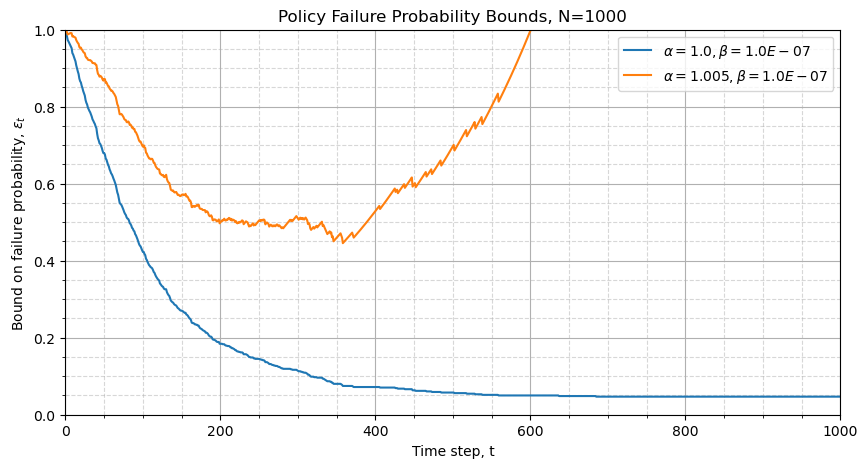

In [ ]:
fig, ax = scenario_database.plot_epsilons(
    plot_empirical=False,
    confs=[0.9999999],
    alphas=[1.0, 1.005],
)

In [ ]:
print(
    scenario_database.get_selected_epsilons(t_steps=[10, 45, 100, 900], conf=0.9999999)
)

[0.93543243 0.70320129 0.42287445 0.04692078]


In [ ]:
# obs, info = envs.reset(seed=[seed + i for i in range(num_envs)])

# with torch.no_grad():  # no gradient needed for testing
#     for global_step in tqdm(range(5)):
#         act = torch.Tensor(
#             np.array([envs.single_action_space.sample() for _ in range(num_envs)])
#         )
#         # act, _ = agent.pi.forward(torch.Tensor(obs).to(device), with_log_prob=False)
#         next_obs, rew, cost, term, trunc, info = envs.step(act.detach().cpu().numpy())
#         obs = next_obs
# print(info)

In [23]:
obs, info = envs.reset(seed=[seed + i for i in range(num_envs)])
print(info)
next_obs, rew, cost, term, trunc, info = envs.step(act.detach().cpu().numpy())
print(info)

{}
{'cost_hazards': array([0., 0., 0., 0.]), '_cost_hazards': array([ True,  True,  True,  True]), 'cost_sum': array([0., 0., 0., 0.]), '_cost_sum': array([ True,  True,  True,  True]), 'constraint_violated': array([False, False, False, False]), '_constraint_violated': array([ True,  True,  True,  True]), 'goal_met': array([False, False, False, False]), '_goal_met': array([ True,  True,  True,  True])}
